# Sentiment Analysis by mBERT for Italian

Importing Libraries

In [1]:
!pip install langdetect
!pip install pretwita
!pip install contractions
!pip install emoji --upgrade
!pip install transformers
!pip install torch
!pip install torchtext
!pip install datasets

!pip install simplemma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=33929a88566f55334944841b917939a53c7718e1b069ec6833fa07a3b424fe4d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━

In [2]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import os
import re
import string
import emoji
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from textblob import TextBlob
from nltk.stem import SnowballStemmer
stemmer_snowball = SnowballStemmer('italian')

# Data preprocessing
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Define stop words for text cleaning
stop_words = set(stopwords.words('italian'))

# Initialize lemmatizer for text cleaning
import simplemma

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Transformers library for BERT
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

from pretwita import PreTwITA as PTW
from pretwita.patterns import get_hashtags

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-396f1c9de9f4>:58: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Data Import

In [3]:
from datasets import load_dataset
dataset_it = load_dataset("cardiffnlp/tweet_sentiment_multilingual", 'italian')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset tweet_sentiment_multilingual downloaded and prepared to /root/.cache/huggingface/datasets/cardiffnlp___tweet_sentiment_multilingual/italian/0.1.0/936afd3cde120393429606f681b3b48d526873c45114068973f71e296ce80605. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
test_it=pd.DataFrame(dataset_it["test"])
validation_it=pd.DataFrame(dataset_it["validation"])
train_it=pd.DataFrame(dataset_it["train"])

In [5]:
train_it.head()

,text,label
0,@user mi fa sbagliare tutte le paroleeeee.,0
1,@user perfetto hai visto poi alla fine anche o...,1
2,"Rutelli: appoggio al governo #monti, sta lavor...",2
3,RT @user: Non legalizzano la #cannabis Ma iper...,0
4,"@user @user @user c'è da vergognarsi, ha fatto...",1


In [6]:
train_it.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1839 non-null   object
 1   label   1839 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.9+ KB


First we rename the columns using shorter words for easier reference.

In [7]:
train_it = train_it.rename(columns={'label': 'sentiment'})
test_it = test_it.rename(columns={'label': 'sentiment'})
validation_it = validation_it.rename(columns={'label': 'sentiment'})

# Data Preparation: Preprocessing

Next, we will define custom functions to clean the texts of the tweets.

In [8]:
# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    ptw = PTW(tweet)
    tweet = ptw.clean(placeholder=False, additional_stopwords=None, keep_dates=True).text
    return tweet

In [9]:
train_it['text_clean'] = [clean_tweet(tweet) for tweet in train_it['text']]
test_it['text_clean'] = [clean_tweet(tweet) for tweet in test_it['text']]
validation_it['text_clean'] = [clean_tweet(tweet) for tweet in validation_it['text']]

In [10]:
train_it

,text,sentiment,text_clean
0,@user mi fa sbagliare tutte le paroleeeee.,0,fa sbagliare tutte paroleeeee
1,@user perfetto hai visto poi alla fine anche o...,1,perfetto visto poi fine oggi passato
2,"Rutelli: appoggio al governo #monti, sta lavor...",2,rutelli appoggio governo lavorando bene
3,RT @user: Non legalizzano la #cannabis Ma iper...,0,rt legalizzano iper tassano cartine geni finanza
4,"@user @user @user c'è da vergognarsi, ha fatto...",1,cè vergognarsi fatto bene cancellare profilo lol
...,...,...,...
1834,@user HAHAHAHAHAHAHAHAHAHAHAHAHAHAH non è un p...,1,hahahahahahahahahahahahahahah porno fine
1835,@user sii è tutto meraviglioso djjdhdsjdh,2,sii meraviglioso djjdhdsjdh
1836,Il governo Monti è troppo tenero con gli sprec...,0,governo monti troppo tenero sprechi casta poli...
1837,Il governo Monti e la manovra salva Italia http,1,governo monti manovra salva italia http


In [11]:
train_it.drop_duplicates("text_clean", inplace=True)
test_it.drop_duplicates("text_clean", inplace=True)
validation_it.drop_duplicates("text_clean", inplace=True)

In [12]:
train_it.sentiment.value_counts()
test_it.sentiment.value_counts()
validation_it.sentiment.value_counts()

0    108
1    108
2    108
Name: sentiment, dtype: int64

# Tweets length analysis

In [13]:
train_it['text_len'] = [len(text.split()) for text in train_it.text_clean]
test_it['text_len'] = [len(text.split()) for text in test_it.text_clean]
validation_it['text_len'] = [len(text.split()) for text in validation_it.text_clean]

In [14]:
max_len = np.max(train_it['text_len'])
max_len

17

# BERT Classification

## Train - Validation - Test split

In [15]:
X_train = train_it['text_clean'].values
y_train = train_it['sentiment'].values

In [16]:
X_test = test_it['text_clean'].values
y_test = test_it['sentiment'].values

In [17]:
X_valid = validation_it['text_clean'].values
y_valid = validation_it['sentiment'].values

# BERT Tokenization

In [20]:
tokenizer =  AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")

In [21]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-multilingual-uncased', vocab_size=105879, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [22]:
def Itabert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [23]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  30


In [24]:
MAX_LEN = 128

In [25]:
train_inputs, train_masks = Itabert_tokenizer(X_train)
val_inputs, val_masks = Itabert_tokenizer(X_valid)
test_inputs, test_masks = Itabert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Data preprocessing for PyTorch BERT model

In [26]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

In [27]:
batch_size = 16

In [28]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

In [29]:
class ItaBert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(ItaBert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 3

        # Instantiate BERT model
        self.bert =  AutoModel.from_pretrained("bert-base-multilingual-uncased")

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [30]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    Itabert_classifier = ItaBert_Classifier(freeze_bert=False)

    Itabert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(Itabert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return Itabert_classifier, optimizer, scheduler

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=10

In [32]:
Itabert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use

# BERT Training

In [33]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def Itabert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###

        # Put the model into the evaluation mode
        model.eval()

        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)

        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")

    print("Training complete!")

In [34]:
Itabert_train(Itabert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   1.059632   |   36.06  
   114    |   1.013649   |   4.43   
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   1.054034    |  1.061612  |       42.86       |   42.70  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.985324   |   34.19  
   114    |   0.913459   |   4.64   
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.976576    |  0.993852  |       57.74

# BERT Prediction

In [35]:
def bert_predict(model, test_dataloader):

    # Define empty list to host the predictions
    preds_list = []

    # Put the model into evaluation mode
    model.eval()

    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]

        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)

        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [36]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

Then we can call the defined function and get the class predictions of the test data.

In [37]:
Itabert_preds = bert_predict(Itabert_classifier, test_dataloader)

In [38]:
sentiments = ['Negative','Neutral','Positive']

In [39]:
print('Classification Report for BERT :\n', classification_report(y_test, Itabert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    Negative       0.65      0.32      0.43       288
     Neutral       0.52      0.72      0.60       285
    Positive       0.49      0.56      0.52       290

    accuracy                           0.53       863
   macro avg       0.56      0.53      0.52       863
weighted avg       0.56      0.53      0.52       863



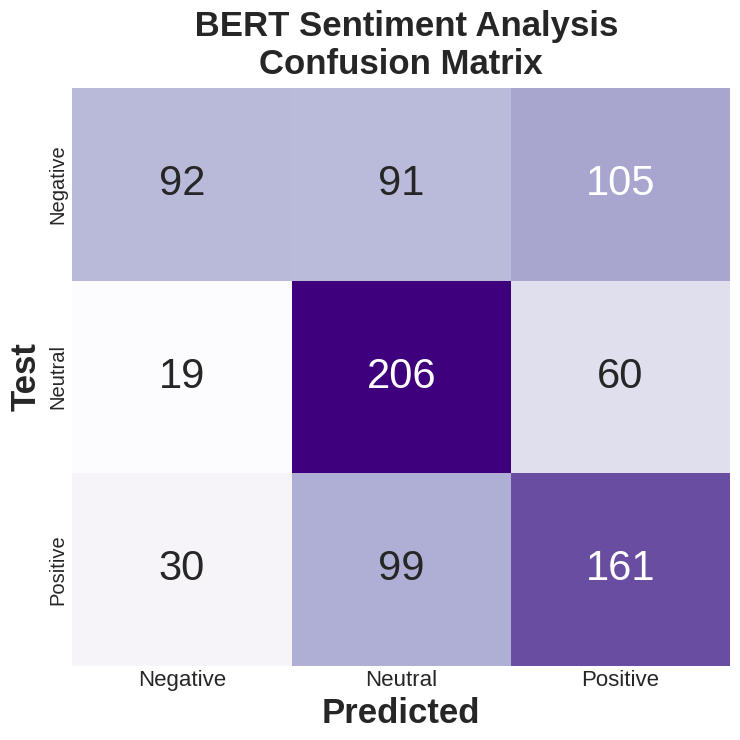

In [40]:
conf_matrix(y_test, Itabert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)